### SA with native bootstrapping

In [1]:

import sys

sys.path.append("../../src")
import stochastic_benchmark as SB
import numpy as np
import os
import bootstrap
import interpolate
import stats
from utils_ws import *
import pickle

In [2]:
here = os.getcwd()
parameter_names = [
    "num_sweeps",   
    "num_reads",   
    "num_shots"         
]  # think about whether iterations should be a parameter or not.
instance_cols = [
    "instance"
]  # indicates how instances should be grouped, default is ['instance']

## Response information
response_key = "Response"  # Column with the response
response_dir = 1  # whether we want to maximize (1) or minimize (-1), default is 1

## Optimizations informations
recover = True  # Whether we want to read dataframes when available, default is True
reduce_mem = True  # Whether we want to segment bootstrapping and interpolation to reduce memory usage, default is True
smooth = True  # Whether virtual best should be monontonized, default is True



# creating stochastic benchmark object
sb = SB.stochastic_benchmark(
    parameter_names=parameter_names,
    here=here,
    instance_cols=instance_cols,
    response_key=response_key,
    reduce_mem=reduce_mem,
    smooth=smooth,
    
)



.p data conversion to .pkl 20 files 
each containing many rows for runs on varying params on same instance

In [6]:
# Convert raw .p files to framework format, then use run_Bootstrap()
# Framework expects: exp_raw/*.pkl with columns [parameters, instance, response, resource]
# Each row = one run (not bootstrapped)
# Convert raw .p files to framework format -
import glob
from itertools import chain
import success_metrics

raw_dir = 'raw_run_pkl'
if not os.path.exists(raw_dir):
    os.makedirs(raw_dir)

sweeps = list(chain(range(1, 250, 1), range(250, 1001, 10)))
schedule = 'geometric'


# First pass: Compute min_energy and random_energy for each instance from raw data

instance_energies = {}

for instance_id in range(20):
    all_energies = []
    random_energies = []  # From low sweep values
    
    for sweep in sweeps:
        filename = f'raw_runs/{instance_id}_{schedule}_{sweep}.p'
        
        if not os.path.exists(filename):
            continue
        
        with open(filename, 'rb') as f:
            samples = pickle.load(f)
        
        energies = np.array(samples.data_vectors['energy'])
        all_energies.extend(energies)
        
        # Use first few sweeps (1-10) to estimate random energy
        if sweep <= 10:
            random_energies.extend(energies)
    
    # Compute instance-specific values from raw data
    min_energy = np.min(all_energies)  # Best energy found
    random_energy = np.mean(random_energies)  # Average random energy
    
    instance_energies[instance_id] = {
        'min_energy': min_energy,
        'random_energy': random_energy
    }
    
    print(f"  Instance {instance_id}: min={min_energy:.2f}, random={random_energy:.2f}")



# Second pass: Convert to framework format using computed values
# Each .p file has 1000 energy samples. Bootstrap expects individual rows (not arrays)
# For each (sweep, num_reads) combo, we'll create multiple rows from the 1000 samples
# Bootstrap will resample these rows with replacement

reads_values = [1, 10, 1000]

for instance_id in range(20):
    raw_records = []
    min_energy = instance_energies[instance_id]['min_energy']
    random_energy = instance_energies[instance_id]['random_energy']
    
    for sweep in sweeps:
        filename = f'raw_runs/{instance_id}_{schedule}_{sweep}.p'
        
        if not os.path.exists(filename):
            continue
        
        with open(filename, 'rb') as f:
            samples = pickle.load(f)
        
        # Get all 1000 energies and convert to approx_ratios
        energies = np.array(samples.data_vectors['energy'])
        approx_ratios = (random_energy - energies) / (random_energy - min_energy)
        
        # Each energy becomes a separate row for EACH num_reads value
        # Bootstrap will group by (instance, num_sweeps, num_reads, num_shots) and resample
        for num_reads in reads_values:
            for approx_ratio in approx_ratios:
                raw_records.append({
                    'instance': instance_id,
                    'num_sweeps': sweep,
                    'num_reads': num_reads,
                    'num_shots': 1,
                    'approx_ratio': approx_ratio,  # Scalar value
                    'resource': sweep
                })
    
    if raw_records:
        pd.DataFrame(raw_records).to_pickle(f'{raw_dir}/instance_{instance_id}.pkl')
        print(f"  Instance {instance_id}: {len(raw_records)} rows")




  Instance 0: min=-239.36, random=-195.76
  Instance 1: min=-244.68, random=-198.07
  Instance 2: min=-237.95, random=-194.59
  Instance 3: min=-229.03, random=-188.31
  Instance 4: min=-240.79, random=-195.27
  Instance 5: min=-234.14, random=-190.14
  Instance 6: min=-235.31, random=-191.84
  Instance 7: min=-232.11, random=-193.68
  Instance 8: min=-229.49, random=-187.11
  Instance 9: min=-235.07, random=-191.63
  Instance 10: min=-238.98, random=-195.29
  Instance 11: min=-233.89, random=-190.16
  Instance 12: min=-234.56, random=-192.00
  Instance 13: min=-231.57, random=-190.22
  Instance 14: min=-228.63, random=-188.70
  Instance 15: min=-237.50, random=-193.95
  Instance 16: min=-230.31, random=-191.29
  Instance 17: min=-239.20, random=-198.02
  Instance 18: min=-248.83, random=-195.23
  Instance 19: min=-239.71, random=-193.63
  Instance 0: 975000 rows
  Instance 1: 975000 rows
  Instance 2: 975000 rows
  Instance 3: 975000 rows
  Instance 4: 975000 rows
  Instance 5: 975000

In [7]:
# Bootstrapping 

# Bootstrap using framework's run_Bootstrap()
shared_args = {
    "response_col": "approx_ratio",
    "resource_col": "resource",
    "response_dir": 1,
    "confidence_level": 68,
}

boots_range = [1, 10, 1000]

bsParams = bootstrap.BootstrapParameters(
    shared_args=shared_args,
    update_rule=lambda bs_params, df: None,
    success_metrics=[success_metrics.Response],
    metric_args={'Response': {'opt_sense': 1}},
    keep_cols=[]  # Empty All grouping columns auto-restored by reset_index()
)

bs_iter = bootstrap.BSParams_range_iter()(bsParams, boots_range)

def group_name_fcn(filepath):
    import os
    filename = os.path.basename(filepath)
    instance_id = filename.split('_')[1].split('.')[0]
    return f'inst={instance_id}'

sb.here.raw_data = raw_dir
sb.run_Bootstrap(bs_iter, group_name_fcn=group_name_fcn)

In [8]:
# Interpolation

if os.path.exists('checkpoints/interpolated_results.pkl'):
    os.remove('checkpoints/interpolated_results.pkl') # remove existing file for fresh interpolation

def resource_fcn(df):
    return df["boots"] * df["num_sweeps"] * df["num_reads"]

iParams = interpolate.InterpolationParameters(resource_fcn, parameters=parameter_names)
sb.run_Interpolate(iParams)

# Verify required columns before Stats
print([c for c in ['num_sweeps','num_reads','num_shots','boots','resource'] if c in sb.interp_results.columns])

  0%|          | 0/975 [00:00<?, ?it/s]

100%|██████████| 975/975 [00:01<00:00, 593.09it/s]


['num_sweeps', 'num_reads', 'num_shots', 'boots', 'resource']


In [6]:
# Cell for implementing without interpolation and with bootstrapping 

In [9]:

# training.check_split_validity = False
# stats groupby Stats groups by ['num_sweeps','num_reads','num_shots','boots','resource']. 
# Without reset_index(), those parameters remained in the MultiIndex, not in df.columns
train_test_split = 0.8
metrics = ["Response"]
stParams = stats.StatsParameters(metrics=metrics, stats_measures=[stats.Median()])
sb.run_Stats(stParams, train_test_split)




100%|██████████| 33950/33950 [00:22<00:00, 1542.73it/s]


In [10]:
#the virtual best baseline
sb.run_baseline()


In [11]:
# Projection Experiments
sb.run_ProjectionExperiment("TrainingStats", None, None)
sb.run_ProjectionExperiment("TrainingResults", None, None)


In [12]:
# Plot the performance and parameters
import plotting

plotting.monotone = True
sb.initPlotting()


100%|██████████| 100/100 [00:00<00:00, 1319.82it/s]

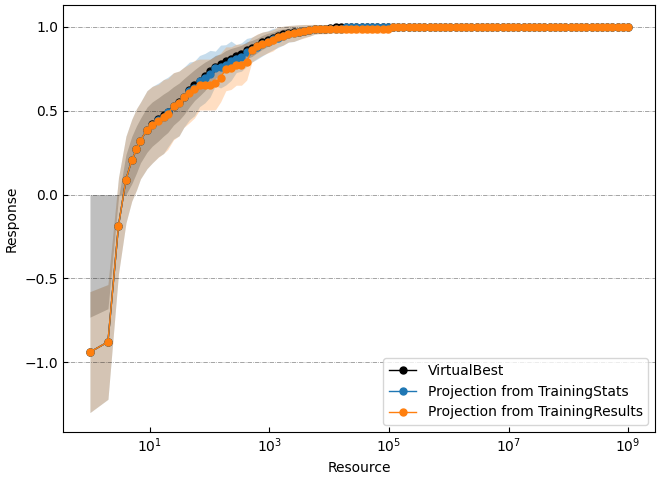

In [13]:
fig, axs = sb.plots.plot_performance()
fig.savefig("performance.png")


100%|██████████| 100/100 [00:00<00:00, 1115.39it/s]


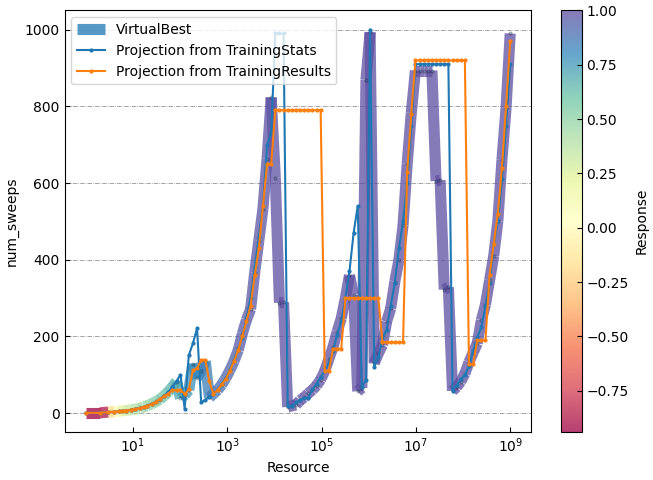

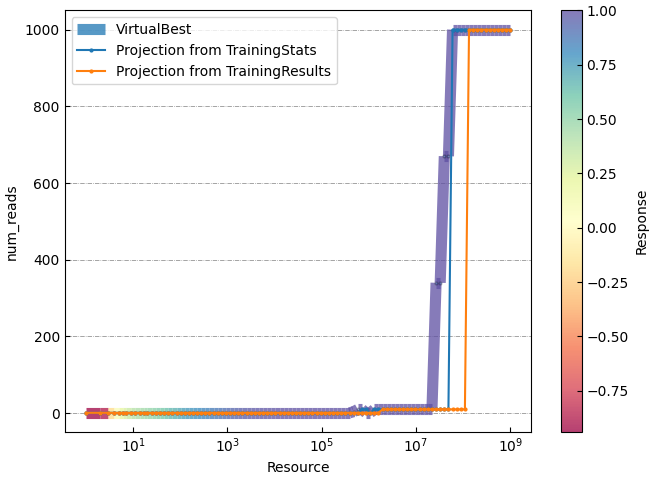

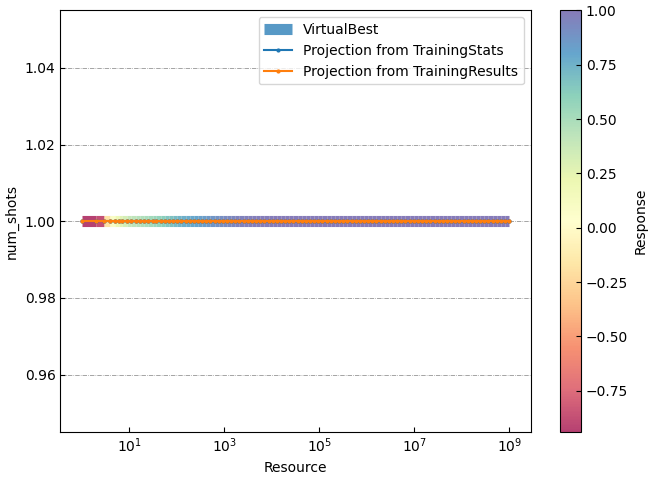

In [14]:
figs, axes = sb.plots.plot_parameters_separate()
for param, fig in figs.items():
    fig.savefig(param + ".png")


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1825.69it/s]


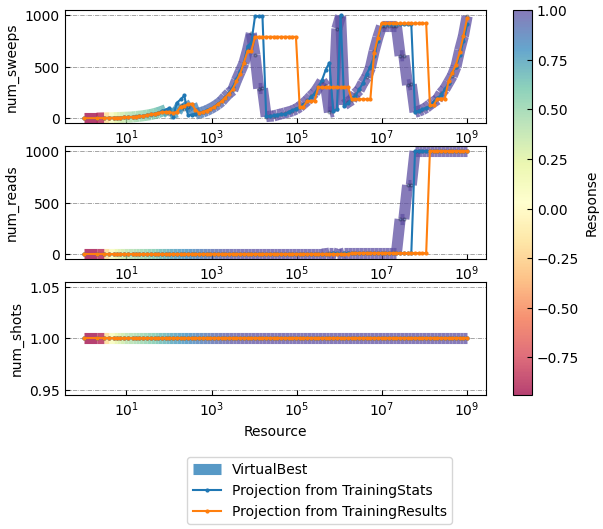

In [15]:
fig, axes = sb.plots.plot_parameters_together()
fig.savefig("all_params.png")
